In [59]:
from lifelines import KaplanMeierFitter,NelsonAalenFitter,WeibullFitter,CoxPHFitter, WeibullAFTFitter
import lifelines.datasets as dt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.statistics import logrank_test
import pickle as pkl
warnings.filterwarnings("ignore")
#get survival dataset
df = dt.load_psychiatric_patients()

## Toy Example of Survival Analysis

For this example, a simple dataset is loaded from lifelines. We can see we have a time feature, and a censorship or event feature. We also have two additional features to work with ,describing attributes of the various patients.

In [60]:
#let's see the head of the dataset
df.head()

,Age,T,C,sex
0,51,1,1,2
1,58,1,1,2
2,55,2,1,2
3,28,22,1,2
4,21,30,0,1


Let's turn sex into a binary (only for the prupose of this dataset)

In [61]:
#instantiate the encoder
le_s = LabelEncoder()
#transform
sex_lis = le_s.fit_transform(df['sex'])
#put in data
df['sex'] = sex_lis

## Creating The Survival Models

Let's start working on the base survival curve. We first isolate the time and event columns

In [62]:
#get the list of time
T = df['T']
#get the list of event occurances
E = df['C']

We start by fitting the Kaplan Meier curve. Using the time and event occurence.

<AxesSubplot:xlabel='timeline'>

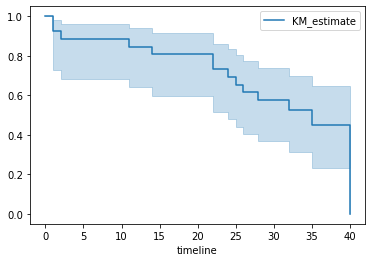

In [63]:
#instantiate kaplan meier curve
km = KaplanMeierFitter()
#fit the curve using the kaplan meier method
km.fit(T,event_observed = E)
#plot the kaplan meier curve
km.plot()

Using the same data as the Kaplan Meier curve, the Nelson Aalen hazard curve is fit

<AxesSubplot:xlabel='timeline'>

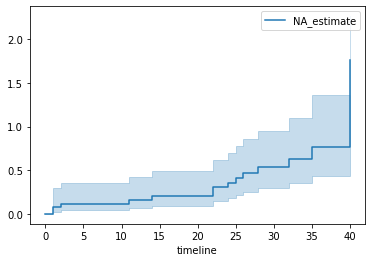

In [5]:
#instantiate nelson aalen fitter
na = NelsonAalenFitter(nelson_aalen_smoothing = False)
#fit the nelson aalen curve
na.fit(T, event_observed = E)
#plot the nelson aalen curve
na.plot()

We can compare the curves of different groups using the log-rank test

In [6]:
male_group = df[df['sex'] == 1]
female_group = df[df['sex'] == 2]


results = logrank_test(male_group['T'], female_group['T'], event_observed_A=male_group['C'], event_observed_B=female_group['C'])
print(results)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.61 0.20      2.29


In this example we fail to reject the null hypothesis, thus there is no difference between the two survival groups

## Parametric Fitting

The Weibull Fitter is a parametric survival modeing technique that will allow us to fit a function to the survival data, both for the survival curve and the hazard curve.

<AxesSubplot:>

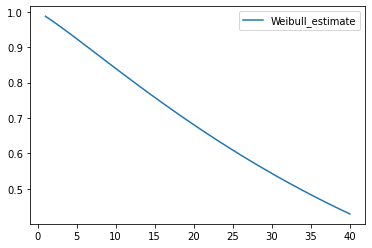

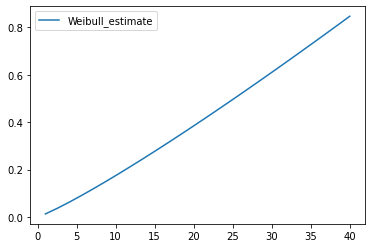

In [7]:
#instantiate the weibull fitter curve
wf = WeibullFitter()
#fit the weibull curve
wf.fit(T,event_observed = E)
#plot the survival function
wf.survival_function_.plot()
#plot the cumulative hazard curve
wf.cumulative_hazard_.plot()

In [8]:
#make a prediction using your parametric curve
wf.predict(41)

0.41837764383974685

## Incorporating Other Features

Using the additional features, we fit a CoxPH model to the data. We can create unique survival curves using this method.

In [9]:
#instantiate the CoxPHFitter model
cph = CoxPHFitter()
#fit the coxph model on the data
cph.fit(df, duration_col = 'T', event_col = 'C')
#print the coxph summary
cph.print_summary()
#get hazard ratios
cph.hazard_ratios_

<lifelines.CoxPHFitter: fitted with 26 total observations, 12 right-censored observations>
             duration col = 'T'
                event col = 'C'
      baseline estimation = breslow
   number of observations = 26
number of events observed = 14
   partial log-likelihood = -27.25
         time fit was run = 2023-04-13 12:01:35 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Age         0.21       1.23       0.06             0.09             0.32                 1.10                 1.38
sex        -0.52       0.59       0.74            -1.97             0.92                 0.14                 2.51

            cmp to     z      p   -log2(p)
covariate                                 
Age           0.00  3.56 <0.005      11.40
sex           0.00 -0.71   0.48       1.07
---
Concordance = 0.82
Partial AIC = 58.50
log-likelihood ratio test = 20.91 on 2 df
-log2(p) of ll-ratio test = 15.08

covariate
Age    1.230629
sex    0.592300
Name: exp(coef), dtype: float64

Let's get some of the unique survival curves from the CoxPH model

<AxesSubplot:>

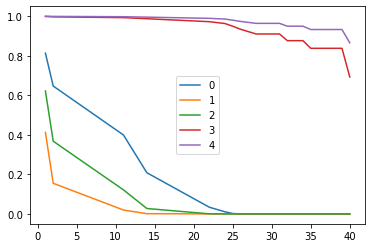

In [10]:
#create the inputs
X = df.drop(['T','C'],axis=1)
#create the survival functions using the coxph fitter for the first 5 entities
survival_cph = cph.predict_survival_function(X[0:5])
#plot the survival functions
survival_cph.plot()

Let's take a look at the hazard curves

<AxesSubplot:>

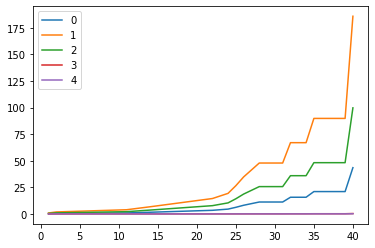

In [11]:
#get unique hazard curves
hazard_cph = cph.predict_cumulative_hazard(X[0:5])
#plot unique hazard curves
hazard_cph.plot()

## AFT Modeling

Now let's make unique weibull functions based on these covariates

In [12]:
#create the weibull aft fitter
waft = WeibullAFTFitter()
#fit the weibull aft fitter to the data
waft.fit(df, duration_col = 'T', event_col = 'C')
#get hazard ratios
waft.hazard_ratios_

param    covariate
lambda_  Age             0.891682
         sex             1.136319
         Intercept    1944.082192
rho_     Intercept       1.729414
Name: exp(coef), dtype: float64

Now let's see how our unique AFT survival functions look like.

<AxesSubplot:>

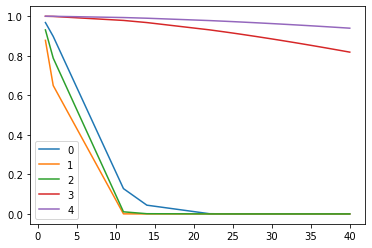

In [13]:
#create the survival function for the first 5 individuals
survival_waft = waft.predict_survival_function(X[0:5])
#plot the survival curves using the aft fitter
survival_waft.plot()

Let's take a look at the hazard curves

<AxesSubplot:>

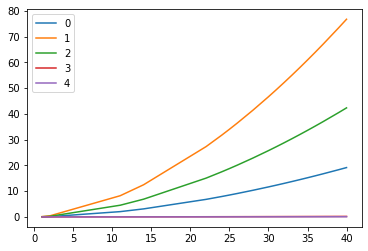

In [14]:
#get unique hazard curves
hazard_waft = waft.predict_cumulative_hazard(X[0:5])
#plot unique hazard curves
hazard_waft.plot()

Predict the survival based on covariates

In [47]:
#predict survival using the aft fitter
waft.predict_survival_function(X.loc[0,:], times = 50)

,0
50.0,5.680538e-13


Let's save our model for the dashboard

In [50]:
#create file
file_waft = open('models/waft_model.pkl','wb')
#save the model
pkl.dump(waft,file_waft)
#close the file
file_waft.close()

## Example Using Turnover Dataset

In [16]:
#read in the turnover data
df_turnover = pd.read_csv('data/HR_Analytics.csv')

Let's take a look at our dataset

In [17]:
#get head of the data
df_turnover.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


Let's see if there are any nulls within the dataset

In [18]:
#let's take a look at the sum of nulls
df_turnover.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

For our timeline, we're using YearsAtCompany since this represents the time an entity spends within the system the best.  . 

Let's look at the distributions of timelines and attrition. We can see that more people tend to seperate with smaller timelines

<AxesSubplot:ylabel='Frequency'>

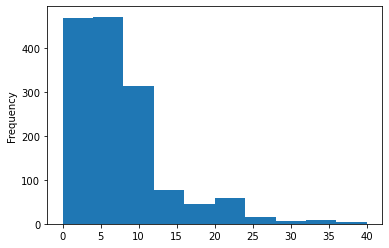

In [19]:
#distribution of turnover rate
df_turnover['YearsAtCompany'].plot(kind='hist')

An attrition of yes means there is a seperation, we can see that there are far more retained individuals than seperated

<AxesSubplot:xlabel='Attrition'>

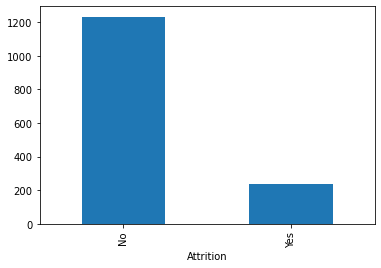

In [20]:
#let's take a look at the attrition rate distribution
df_turnover.groupby(['Attrition']).count()['EmployeeNumber'].plot(kind='bar')

We notice our attrition is yes or no rather than 1 or 0, so we have to encode this variable to be numerical

In [21]:
#instantiate the encoder
le = LabelEncoder()
#transform the data
encoded_attrition = le.fit_transform(df_turnover['Attrition'])
#change attrition to 0 or 1
df_turnover['Attrition'] = encoded_attrition

For the sake of simplicity, let's filter out people who were employed for less than one year. 

In [22]:
#filter years at company to be greater than 1
df_turnover = df_turnover[df_turnover['YearsAtCompany']>0]

## Creating the Survival Models

Let's start repeating the previous process

In [23]:
#get list of times
T_turnover = df_turnover['YearsAtCompany']
#get list of events
E_turnover = df_turnover['Attrition']

Let's create the Kaplan Meier curve

<AxesSubplot:xlabel='timeline'>

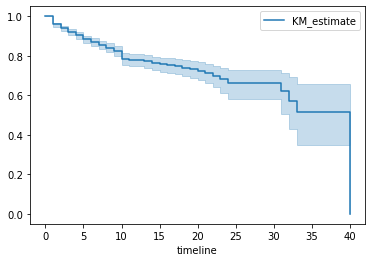

In [24]:
#instantiate kaplan meier curve
km_turnover = KaplanMeierFitter()
#fit the curve using the kaplan meier method
km_turnover.fit(T_turnover,event_observed = E_turnover)
#plot the kaplan meier curve
km_turnover.plot()

Let's create the hazard curve

<AxesSubplot:xlabel='timeline'>

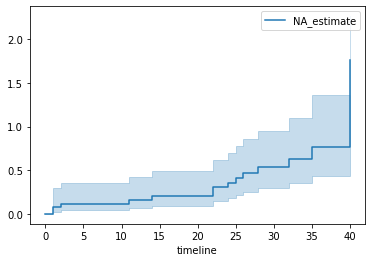

In [25]:
#instantiate nelson aalen fitter
na_turnover = NelsonAalenFitter(nelson_aalen_smoothing = False)
#fit the nelson aalen curve
na_turnover.fit(T, event_observed = E)
#plot the nelson aalen curve
na_turnover.plot()

## Parametric Modeling

Now let's fit a weibull function to the hazard and survival curve 

<AxesSubplot:>

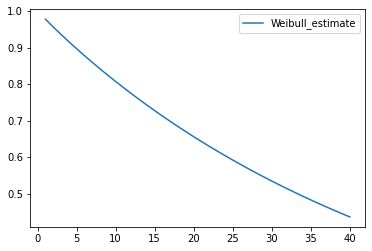

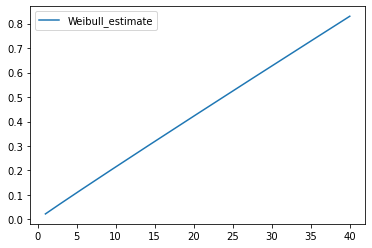

In [26]:
#instantiate the weibull fitter curve
wf_turnover = WeibullFitter()
#fit the weibull curve
wf_turnover.fit(T_turnover,event_observed = E_turnover)
#plot the survival function
wf_turnover.survival_function_.plot()
#plot the cumulative hazard curve
wf_turnover.cumulative_hazard_.plot()

Make a survival prediction

In [45]:
#make a prediction using your parametric curve
wf_turnover.predict(41)

0.42736426861085636

## Incorporating Other Features

Now let's create our CoxPH model. For this example, I chose a subset of features. You can play around with the additional feautres from the dataset, and see how it affects our unique survival curves. 

In [27]:
#get some chosen columns
multi_survival_df = df_turnover[['YearsAtCompany',
                                 'Attrition',
                                 'Gender', 
                                 'EnvironmentSatisfaction',
                                 'Age', 
                                 'WorkLifeBalance',
                                 'PerformanceRating',
                                 'MonthlyIncome'
                                ]]

We should do some brief analytics on our selected features

* Our distribution of ages seems to be rather normal
* We can see that age seems to be rather correlated to years spent at a company
* We can see that monthly income is skewed to favor lower monthly income levels
* There is a slight correlation between years at a company and monthly income

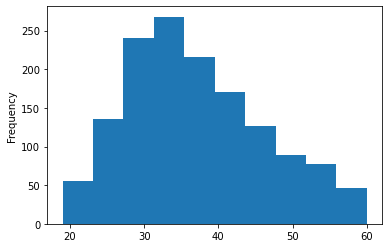

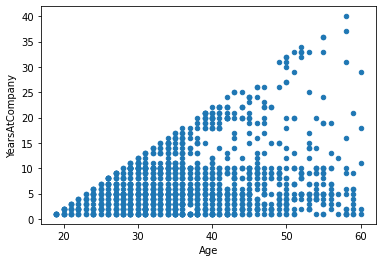

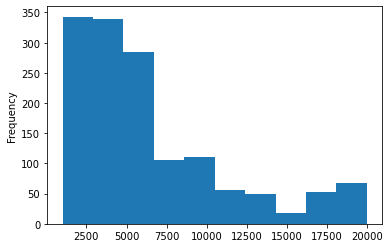

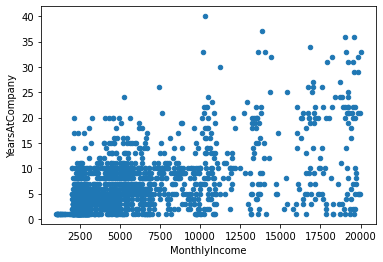

In [28]:
#iterate through columns
for i in ['Age','MonthlyIncome']:
    #plot the histograme
    multi_survival_df[i].plot(kind = 'hist')
    #show the plot
    plt.show()
    #plot the scatterplot between this var and the time of survival
    multi_survival_df.plot(x = i, y = 'YearsAtCompany', kind = 'scatter')
    #show plot
    plt.show()

We can see a semblance of a relationship between age and monthly income.

<AxesSubplot:xlabel='Age', ylabel='MonthlyIncome'>

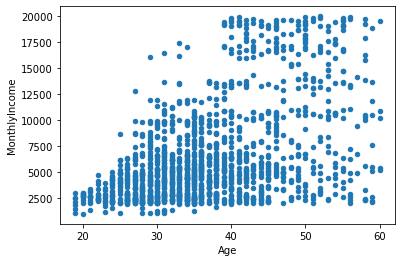

In [29]:
#create scatterplot
multi_survival_df.plot(x = 'Age', y= 'MonthlyIncome', kind = 'scatter')

* We can see that larger attrition rates seem to be correlated to a lower environment satisfaction
* We can see a larger number of seperations for male workers, however with a lower number of female workers, it seems gender does not to experience much of a seperation difference
* Work life balance has a paritcularly low rate for 4, even considering the lower number of individuals in that cateogry. The rest of the categories seem to be consistent with the number of individuals in that category
* While there is a higher number of seperations with lower performance, however more people were performing in the lower category

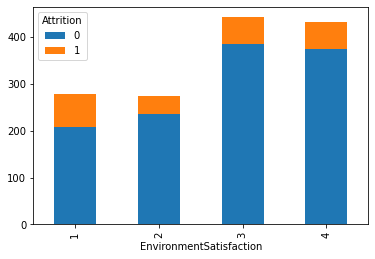

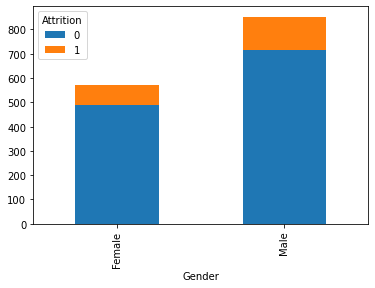

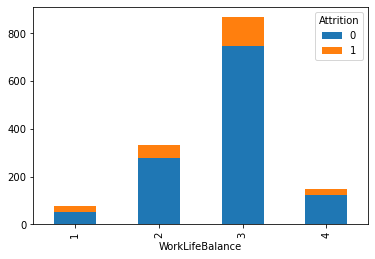

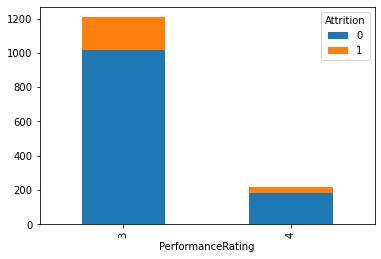

In [30]:
#iterate through the categorical features
for i in ['EnvironmentSatisfaction', 'Gender', 'WorkLifeBalance', 'PerformanceRating']:
    #create the stacked bar chart
    multi_survival_df.groupby([i,'Attrition']).count()['YearsAtCompany'].unstack().plot(kind = 'bar', stacked = True)
    #show plot
    plt.show()

Let's look at some potential trends between our other categorical/nominal features
* It's difficult to notice any trends between worklife balance and gender
* It's difficult to notice any trends between environmental satisfaction and gender
* Worklife balance vs environmental satisfaction have some odd trends, interestingly 1 on environment satisfaction has the highest frequency of high work life balance. An environmental satisfaction of 4 has a lower rate of highest work life balance compared to an environmental satisfaction of 3.
* Some strange trends can be seen, like the lowest environmental satisfaction has a higher proportion of higher perfomring individual, an environmental satisfaction of 3 seems to have the overall highest perfomring individuals and a higher rate of higher performing individuals than people with an environmental satisfaction of 4. 

<AxesSubplot:xlabel='WorkLifeBalance'>

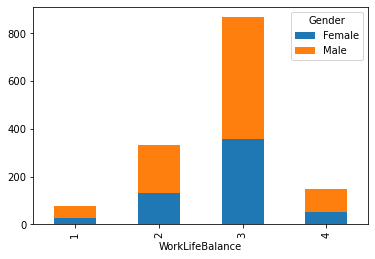

In [31]:
#create the multi bar chart
multi_survival_df.groupby(['WorkLifeBalance','Gender']).count()['Attrition'].unstack().plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='EnvironmentSatisfaction'>

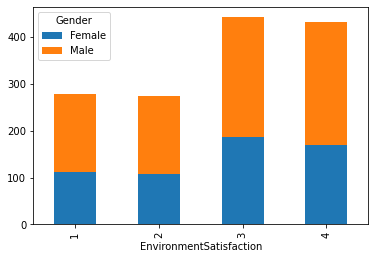

In [32]:
#create the multi bar chart
multi_survival_df.groupby(['EnvironmentSatisfaction','Gender']).count()['Attrition'].unstack().plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='EnvironmentSatisfaction'>

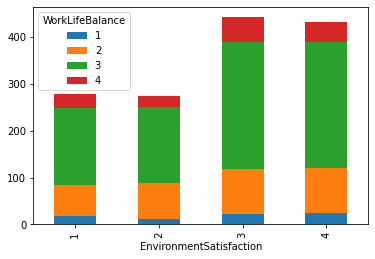

In [33]:
#create the multi bar chart
multi_survival_df.groupby(['EnvironmentSatisfaction','WorkLifeBalance']).count()['Attrition'].unstack().plot(kind = 'bar', stacked = True)

<AxesSubplot:xlabel='EnvironmentSatisfaction'>

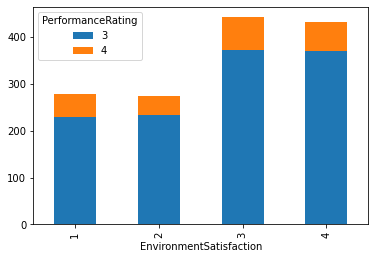

In [34]:
#create the multi bar chart
multi_survival_df.groupby(['EnvironmentSatisfaction','PerformanceRating']).count()['Attrition'].unstack().plot(kind = 'bar', stacked = True)

Now let's take a look at some colored scatterplots, it appears gender and performance don't reveal additional trends within this scatterplot

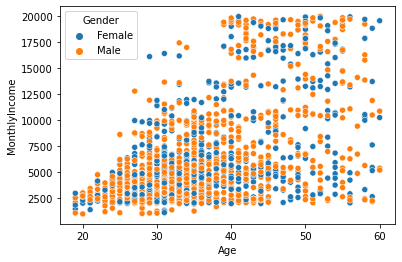

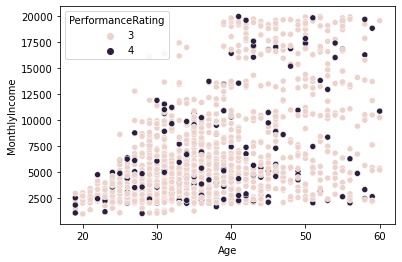

In [35]:
#iterate through some categorical columns
for i in ['Gender','PerformanceRating']:
    #create the colored scatter plot
    sns.scatterplot(data = multi_survival_df, x = 'Age', y= 'MonthlyIncome', hue = i)
    #show the plot
    plt.show()

Let's start by encoding the gender features within our model, we can start by label encoding gender

In [36]:
#instantiate label encoder
le_gender = LabelEncoder()
#transform the data
le_data = le_gender.fit_transform(multi_survival_df['Gender'])
#replace the encoded data within the set
multi_survival_df['Gender'] = le_data

Now let's fit the CoxPH fitter and take a look at some of the qualities 

In [37]:
#instantiate the CoxPHFitter model
cph_turnover = CoxPHFitter(penalizer=0.0001)
#fit the coxph model on the data
cph_turnover.fit(multi_survival_df, duration_col = 'YearsAtCompany', event_col = 'Attrition')
#print the coxph summary
cph_turnover.print_summary()
#get hazard ratios
cph_turnover.hazard_ratios_

<lifelines.CoxPHFitter: fitted with 1426 total observations, 1205 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1426
number of events observed = 221
   partial log-likelihood = -1370.59
         time fit was run = 2023-04-13 12:01:39 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Gender                    0.10       1.11       0.14            -0.17             0.37                 0.84                 1.45
EnvironmentSatisfaction  -0.24       0.79       0.06            -0.36            -0.12                 0.70                 0.89
Age                      -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
WorkLifeBalance          -0.19       0.83       0.09            -0.37            -0.00                 0.69                 1.00
PerformanceRating        -0.09       0.92       0.19            -0.46             0.28                 0.63                 1.33
MonthlyIncome            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                          cmp to     z      p   -log2(p)
covariate                                               
Gender                      0.00  0.71   0.47       1.08
EnvironmentSatisfaction     0.00 -3.88 <0.005      13.24
Age                         0.00 -4.65 <0.005      18.20
WorkLifeBalance             0.00 -2.00   0.05       4.45
PerformanceRating           0.00 -0.47   0.64       0.64
MonthlyIncome               0.00 -7.47 <0.005      43.45
---
Concordance = 0.77
Partial AIC = 2753.18
log-likelihood ratio test = 173.85 on 6 df
-log2(p) of ll-ratio test = 113.49

covariate
Gender                     1.105076
EnvironmentSatisfaction    0.787996
Age                        0.952549
WorkLifeBalance            0.829114
PerformanceRating          0.915738
MonthlyIncome              0.999803
Name: exp(coef), dtype: float64

Let's take a look at the unique survival curves

<AxesSubplot:>

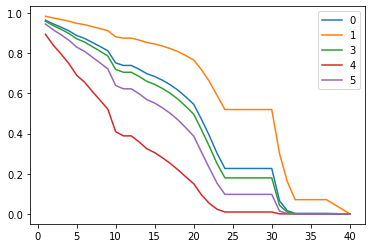

In [38]:
#create the inputs
X_turnover = multi_survival_df.drop(['Attrition','YearsAtCompany'],axis = 1)
#create the survival functions using the coxph fitter for the first 5 entities
survival_cph_turnover = cph_turnover.predict_survival_function(X_turnover[0:5])
#plot the survival functions
survival_cph_turnover.plot()

Let's take a look at the hazard curves

<AxesSubplot:>

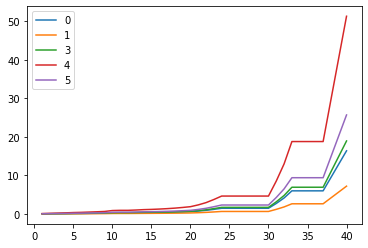

In [39]:
#get unique hazard curves
hazard_cph_turnover = cph_turnover.predict_cumulative_hazard(X_turnover[0:5])
#plot unique hazard curves
hazard_cph_turnover.plot()

## AFT Model

Now let's fit an AFT model to this data

In [40]:
#create the weibull aft fitter
waft_turnover = WeibullAFTFitter()
#fit the weibull aft fitter to the data
waft_turnover.fit(multi_survival_df, duration_col = 'YearsAtCompany', event_col = 'Attrition')
#get summary
waft_turnover.print_summary()
#get hazard ratios
waft_turnover.hazard_ratios_

<lifelines.WeibullAFTFitter: fitted with 1426 total observations, 1205 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
   number of observations = 1426
number of events observed = 221
           log-likelihood = -976.03
         time fit was run = 2023-04-13 12:01:40 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                       
lambda_ Age                       0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
        EnvironmentSatisfaction   0.18       1.20       0.05             0.09             0.28                 1.09                 1.32
        Gender                   -0.09       0.91       0.11            -0.30             0.12                 0.74                 1.13
        MonthlyIncome             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
        PerformanceRating         0.09       1.09       0.15            -0.20             0.38                 0.82                 1.46
        WorkLifeBalance           0.15       1.16       0.07             0.00             0.29                 1.00                 1.34
        Intercept                 0.15       1.16       0.58            -0.98             1.28                 0.37                 3.61
rho_    Intercept                 0.25       1.28       0.06             0.14             0.36                 1.15                 1.43

                                  cmp to     z      p   -log2(p)
param   covariate                                               
lambda_ Age                         0.00  4.47 <0.005      16.97
        EnvironmentSatisfaction     0.00  3.75 <0.005      12.45
        Gender                      0.00 -0.84   0.40       1.33
        MonthlyIncome               0.00  7.53 <0.005      44.20
        PerformanceRating           0.00  0.59   0.56       0.84
        WorkLifeBalance             0.00  2.02   0.04       4.53
        Intercept                   0.00  0.26   0.79       0.33
rho_    Intercept                   0.00  4.48 <0.005      17.05
---
Concordance = 0.77
AIC = 1968.06
log-likelihood ratio test = 187.88 on 6 df
-log2(p) of ll-ratio test = 123.39

param    covariate              
lambda_  Age                        1.035997
         EnvironmentSatisfaction    1.200229
         Gender                     0.912258
         MonthlyIncome              1.000147
         PerformanceRating          1.090568
         WorkLifeBalance            1.159312
         Intercept                  1.162347
rho_     Intercept                  1.280327
Name: exp(coef), dtype: float64

We can also get the unique survival curves

<AxesSubplot:>

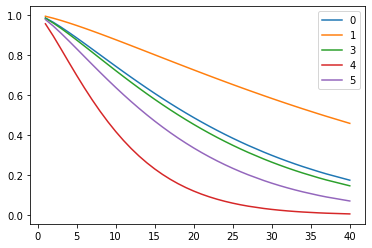

In [41]:
#create the survival function for the first 5 individuals
survival_waft_turnover = waft_turnover.predict_survival_function(X_turnover[0:5])
#plot the survival curves using the aft fitter
survival_waft_turnover.plot()

Let's take a look at the hazard curves

<AxesSubplot:>

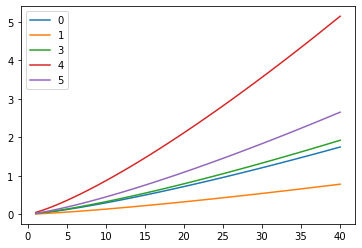

In [42]:
#get uique hazard curves
hazard_waft_turnover = waft_turnover.predict_cumulative_hazard(X_turnover[0:5])
#plot unique hazard curves
hazard_waft_turnover.plot()

Make a prediction based on the AFT fitter

In [44]:
#predict survival using the aft fitter
waft_turnover.predict_survival_function(X_turnover.loc[0,:], times = 50)

,0
50.0,0.097752
